In [2]:
%%capture
!pip install NeuralForecast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (9,6)
from neuralforecast.core import NeuralForecast
from neuralforecast.models import NHITS, NBEATS, TimesNet
from neuralforecast.losses.numpy import mae, mse


In [18]:
%%capture
import yfinance as yf
ticker = '005930.KS'  #005930.KS (삼성) 000660 (하이닉스)
data = yf.download(tickers=ticker, period="730d", interval="1h")
###
for i in range(len(data['Volume'])):
  if data['Volume'][i] == 0:
    data['Volume'][i] = data['Volume'][i+1] * 2
  else:
    pass
data = data.reset_index()
data=data.rename(columns={"Datetime":"ds", "Close":"y"})
data['unique_id'] = 'BE'
data['ds'] = np.arange(len(data))
### Feature 조합
# Open - Close 열 생성
data['O-C'] = data['Open'] - data['y']
# High - Low 열 생성
data['H-L'] = data['High'] - data['Low']
# 2시간 이동평균선 열 생성
data['2Hr_MA'] = data['y'].rolling(window=6).mean()
# 4시간 이동평균선 열 생성
# data['4Hr_MA'] = data['y'].rolling(window=2).mean() # 18
# 6시간 이동평균선 열 생성
data['6Hr_MA'] = data['y'].rolling(window=12).mean()  # 12
# 2시간의 주가의 표쥰편차
# data['2Hr_Std'] = data['y'].rolling(window = 4).std()
# 1의 자리 까지만
# data['2Hr_MA'] = data['2Hr_MA'].round(1)
# data['4Hr_MA'] = data['4Hr_MA'].round(1)
data['6Hr_MA'] = data['6Hr_MA'].round(1)
# data['2Hr_Std'] = data['2Hr_Std'].round(1)
# data['6Hr_Std'] = data['6Hr_Std'].round(1)
# Stochastic Oscillator
data['FastSO'] = ((data['y'] - data['Low'].rolling(window = 18).min()) / (data['High'].rolling(window = 18).max() - data['Low'].rolling(window = 18).min())) * 100 # 12
data['SlowSO'] = data['FastSO'].rolling(window = 6).mean()
# CCI
def cci(data, window=3):
    typical_price = (data['High'] + data['Low'] + data['y']) / 3
    sma = typical_price.rolling(window=window).mean()
    mean_deviation = abs(typical_price - sma).rolling(window=window).mean()
    cci = (typical_price - sma) / (0.015 * mean_deviation)
    return cci
data['CCI'] = cci(data, window = 12) # 12
data.drop(columns=['Open', 'High', 'Low', 'Adj Close'], inplace=True)
### 데이터셋 나누기
f_data = data.iloc[-6:,:]
actual = data.iloc[-6:,:]
data = data.iloc[22:-6 ,:]

In [11]:
data.head(20)

,ds,y,Volume,unique_id,O-C,H-L,2Hr_MA,6Hr_MA,FastSO,SlowSO,CCI
13,13,82400.0,2018798,BE,-300.0,600.0,82016.666667,81950.0,NaN,NaN,NaN
14,14,82700.0,2701766,BE,-300.0,500.0,82166.666667,82025.0,NaN,NaN,NaN
15,15,82600.0,1628969,BE,100.0,300.0,82266.666667,82083.3,NaN,NaN,NaN
16,16,83300.0,4028234,BE,-700.0,800.0,82483.333333,82200.0,NaN,NaN,NaN
17,17,83400.0,3298749,BE,-100.0,400.0,82733.333333,82325.0,95.000000,NaN,NaN
18,18,81700.0,9237118,BE,800.0,900.0,82683.333333,82316.7,10.000000,NaN,NaN
19,19,81500.0,4618559,BE,300.0,300.0,82533.333333,82275.0,0.000000,35.000000,NaN
20,20,81600.0,2962278,BE,0.0,200.0,82350.000000,82258.3,5.000000,5.000000,NaN
21,21,81600.0,3008210,BE,-100.0,100.0,82183.333333,82225.0,5.000000,3.333333,NaN
22,22,81300.0,4464654,BE,300.0,400.0,81850.000000,82166.7,4.347826,4.782609,-95.630668


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:204: UserWarning: val_check_steps is greater than max_steps,                     setting val_check_steps to max_steps
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type          | Params
-------------------------------------------------
0 | loss         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=60` reached.
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:204: UserWarning: val_check_steps is greater than max_steps,                     setting val_check_steps to max_steps
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type          | Params
-------------------------------------------------
0 | loss           | MAE           | 0     
1 | padder_train   | ConstantPad1d | 0     
2 | scaler         | TemporalNorm  | 0     
3 | model          | ModuleList    | 164 K 
4 | enc_embedding  | DataEmbedding | 704   
5 | layer_norm   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=60` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/neuralforecast/tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


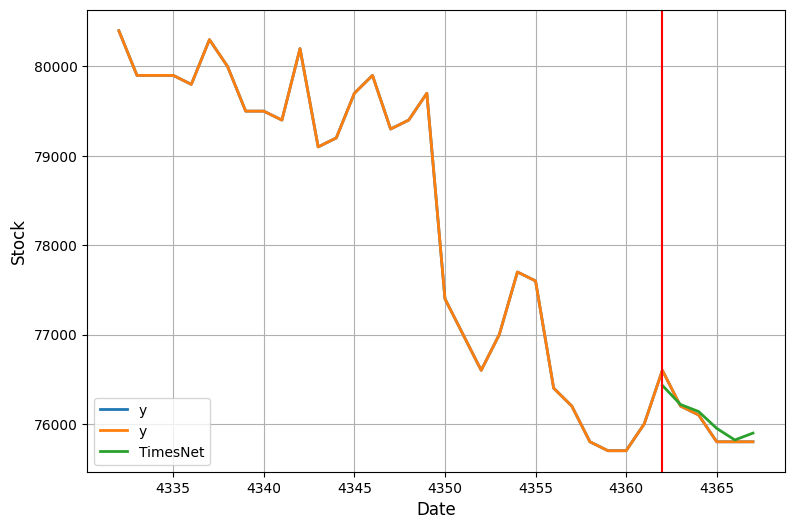

In [21]:
### 모델만들기
horizon = 6 # 6hour(1day) ahead  forecast
models = [TimesNet(h =  horizon,                                                 # Horizon
                 input_size =  2*horizon,                                      # Length of input window
                 max_steps = 60,                                             # Training iterations
                 top_k = 9,                                                   # Number of periods (for FFT).
                 num_kernels = 2,                                             # Number of kernels for Inception module                                       # Learning rate
                 futr_exog_list = ['O-C','H-L','FastSO','2Hr_MA','6Hr_MA','CCI','SlowSO','Volume'], # Future exogenous variables
)]
nf = NeuralForecast(models=models, freq= 1, local_scaler_type='minmax')
nf.fit(df=data)
### Cross Validation
preds_df = nf.cross_validation(df=data, step_size= horizon, n_windows= 2) #상: #120 #24 # 중: #12 #6 #2
preds_df = preds_df.reset_index()

/usr/local/lib/python3.10/dist-packages/neuralforecast/tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


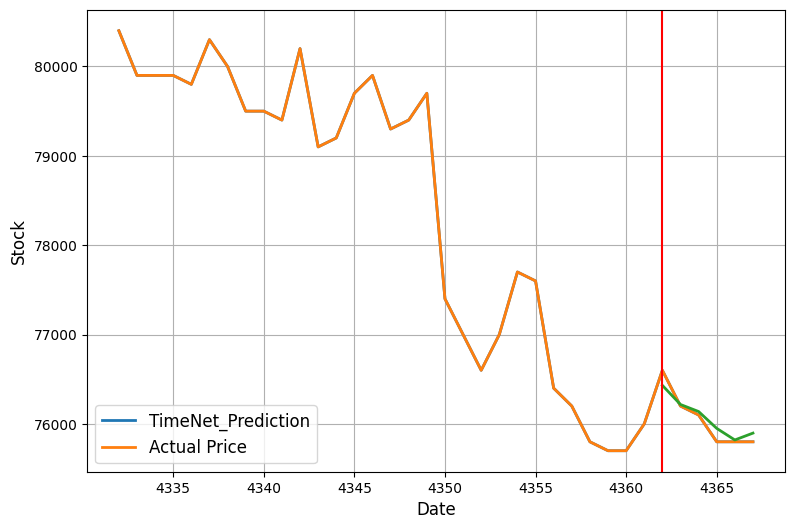

In [45]:
### 최종 결과
Y_hat_df = nf.predict(futr_df = f_data)
Y_hat_df = Y_hat_df.reset_index(drop=False)

plot_df = data[data['unique_id']=='BE'].tail(10*3).reset_index(drop=True)
Y_hat_df = Y_hat_df[Y_hat_df['unique_id']=='BE']
plot_df = pd.concat([plot_df,actual ,Y_hat_df ]).set_index('ds') # Concatenate the train and forecast dataframes
# 각 변수에 대한 선의 색상을 지정하여 그래프를 그립니다.


plot_df[['y','y','TimesNet']].plot(linewidth=2, label=['Actual Price', 'TimeNet_Prediction'])
plt.axvline(actual['ds'].iloc[0], color='red')
plt.ylabel('Stock', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.legend(['TimeNet_Prediction','Actual Price'], fontsize=12)
plt.grid()

In [31]:
plot_df

,y,Volume,unique_id,O-C,H-L,2Hr_MA,6Hr_MA,FastSO,SlowSO,CCI,TimesNet
ds,,,,,,,,,,,
4332,80400.0,10636672.0,BE,800.0,1200.0,81533.333333,82441.7,6.250000,11.955438,-123.494794,NaN
4333,79900.0,6284883.0,BE,400.0,700.0,81216.666667,82100.0,3.846154,10.691701,-121.004477,NaN
4334,79900.0,4427816.0,BE,-100.0,600.0,80966.666667,81775.0,9.090909,12.206853,-100.442930,NaN
4335,79900.0,2234167.0,BE,0.0,400.0,80716.666667,81466.7,9.090909,12.821103,-75.019602,NaN
4336,79800.0,1713636.0,BE,100.0,200.0,80383.333333,81158.3,7.272727,11.330522,-56.878819,NaN
4337,80300.0,3558092.0,BE,-400.0,800.0,80033.333333,80908.3,16.363636,8.652389,-34.792830,NaN
4338,80000.0,5696531.0,BE,700.0,900.0,79966.666667,80750.0,12.244898,9.651539,-23.098417,NaN
4339,79500.0,4698492.0,BE,500.0,1100.0,79900.000000,80558.3,11.538462,10.933590,-51.293735,NaN
4340,79500.0,1347390.0,BE,-100.0,500.0,79833.333333,80400.0,12.000000,11.418439,-48.464047,NaN


In [60]:
street = '서울시'
st = '아파트'
rooms = 3
print(street,'에 위치한 아주 좋은',st,rooms)

서울시 에 위치한 아주 좋은 아파트 3
